In [1]:
! pip install streamlit pypdf2 pillow transformers sentence-transformers torch scikit-learn pymupdf pyngrok

  Using cached pypdf2-3.0.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached transformers-4.47.1-py3-none-any.whl.metadata (44 kB)
  Using cached sentence_transformers-3.3.1-py3-none-any.whl.metadata (10 kB)
  Using cached pymupdf-1.25.1-cp39-abi3-win_amd64.whl.metadata (3.4 kB)
  Using cached pyngrok-7.2.2-py3-none-any.whl.metadata (8.4 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.27.0-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata

In [2]:
import streamlit as st
from pyngrok import ngrok
import fitz
from PIL import Image
import io
from transformers import AutoProcessor, AutoModel, AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import os

c:\Users\yc993\miniconda3\envs\rag\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
! pip install pymupdf pillow transformers sentence-transformers torch scikit-learn tqdm

This is working fine

In [7]:
import fitz
from PIL import Image
import io
from transformers import AutoProcessor, AutoModel, AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import os
from IPython.display import display, Image as IPImage
from tqdm.notebook import tqdm

class MultimodalRAG:
    def __init__(self):
        # Check if GPU is available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        print("Initializing models...")
        # Move models to GPU
        self.text_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        self.text_model.to(self.device)

        self.image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.image_model = AutoModel.from_pretrained("openai/clip-vit-base-patch32")
        self.image_model.to(self.device)

        self.chat_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2")
        self.chat_model.to(self.device)

        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")

        self.text_chunks = []
        self.text_embeddings = []
        self.images = []
        self.image_embeddings = []
        self.image_locations = []
        self.page_text_map = {}
        print("Initialization complete!")

    def chunk_text(self, text, chunk_size=500, overlap=100):
        words = text.split()
        chunks = []
        start = 0

        while start < len(words):
            chunk = ' '.join(words[start:start + chunk_size])
            chunks.append(chunk)
            start += chunk_size - overlap

        return chunks

    def process_text(self, text, page_num):
        if not text.strip():
            return

        if page_num not in self.page_text_map:
            self.page_text_map[page_num] = []

        chunks = self.chunk_text(text)
        for chunk in chunks:
            if len(chunk.strip()) > 50:
                self.text_chunks.append(chunk)
                self.page_text_map[page_num].append(chunk)
                # Move input to GPU for encoding
                embedding = self.text_model.encode(chunk, convert_to_tensor=True)
                # Move back to CPU for storage
                embedding = embedding.cpu().numpy()
                self.text_embeddings.append(embedding)

    def extract_content_from_pdf(self, pdf_path):
        print(f"Processing PDF: {pdf_path}")
        doc = fitz.open(pdf_path)
        total_pages = len(doc)

        for page_num in tqdm(range(total_pages), desc="Processing pages"):
            page = doc[page_num]

            # Extract text
            blocks = page.get_text("blocks")
            for block in blocks:
                text = block[4]
                self.process_text(text, page_num)

            # Extract images
            image_list = page.get_images(full=True)
            for img_index, img in enumerate(image_list):
                try:
                    xref = img[0]
                    base_image = doc.extract_image(xref)
                    image_bytes = base_image["image"]

                    image = Image.open(io.BytesIO(image_bytes))
                    if image.mode == 'RGBA':
                        image = image.convert('RGB')

                    # Move input to GPU
                    inputs = self.image_processor(images=image, return_tensors="pt")
                    inputs = {k: v.to(self.device) for k, v in inputs.items()}

                    with torch.no_grad():
                        image_features = self.image_model.get_image_features(**inputs)

                    self.images.append(image)
                    # Move back to CPU for storage
                    self.image_embeddings.append(image_features.cpu().numpy())
                    self.image_locations.append((page_num, img_index))
                except Exception as e:
                    print(f"Error processing image {img_index} on page {page_num}: {str(e)}")
                    continue

        doc.close()

        if self.text_embeddings:
            self.text_embeddings = np.vstack(self.text_embeddings)

        print(f"Processing complete! Found {len(self.text_chunks)} text chunks and {len(self.images)} images.")

    def search(self, query, top_k=3):
        results = {
            'text': [],
            'images': [],
            'text_locations': [],
            'image_locations': [],
            'context': []
        }

        if len(self.text_chunks) > 0:
            # Move query to GPU for encoding
            text_query_embedding = self.text_model.encode(query, convert_to_tensor=True)
            text_query_embedding = text_query_embedding.cpu().numpy()

            text_similarities = cosine_similarity(
                [text_query_embedding],
                self.text_embeddings
            )[0]

            top_text_indices = np.argsort(text_similarities)[-top_k:][::-1]
            results['text'] = [self.text_chunks[i] for i in top_text_indices]
            results['text_locations'] = top_text_indices

            for idx in top_text_indices:
                page_num = None
                for p, chunks in self.page_text_map.items():
                    if self.text_chunks[idx] in chunks:
                        page_num = p
                        break

                if page_num is not None:
                    context = "\n".join(self.page_text_map[page_num])
                    results['context'].append((context, page_num))

        if len(self.images) > 0:
            # Move query to GPU for processing
            image_query_inputs = self.image_processor(text=[query], return_tensors="pt", padding=True)
            image_query_inputs = {k: v.to(self.device) for k, v in image_query_inputs.items()}

            with torch.no_grad():
                image_query_features = self.image_model.get_text_features(**image_query_inputs)

            # Move back to CPU for similarity calculation
            image_query_features = image_query_features.cpu().numpy()

            image_similarities = cosine_similarity(
                image_query_features,
                np.vstack(self.image_embeddings)
            )[0]

            top_image_indices = np.argsort(image_similarities)[-top_k:][::-1]
            results['images'] = [self.images[i] for i in top_image_indices]
            results['image_locations'] = [self.image_locations[i] for i in top_image_indices]

        return results

    def generate_response(self, query, context):
        prompt = f"""Based on the following context, answer the question.

Context: {context}

Question: {query}

Answer: """

        # Correctly handle tokenizer inputs
        inputs = self.tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.chat_model.generate(
                input_ids,
                attention_mask=attention_mask,
                max_new_tokens=512,
                num_return_sequences=1,
                temperature=0.7,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return response.split("Answer: ")[-1].strip()

    def chat(self, query):
        """Single method to handle the entire chat process"""
        print(f"\nQuestion: {query}\n")

        # Search for relevant content
        results = self.search(query)

        # Combine context from relevant text chunks
        context = ""
        if results['context']:
            context = "\n".join([ctx[0] for ctx in results['context']])

        # Generate and display response
        response = self.generate_response(query, context)
        print(f"Answer: {response}\n")

        # Display relevant images if any
        if results['images']:
            print("Relevant images:")
            for i, (img, loc) in enumerate(zip(results['images'], results['image_locations']), 1):
                print(f"Image from page {loc[0] + 1}:")
                display(img)

Using device: cpu
Initializing models...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Initialization complete!
Processing PDF: C:\Users\yc993\Downloads\final-call\Marma Therapy The Healing Power of Ayurvedic Vital Point Massage.pdf


Processing pages:   0%|          | 0/150 [00:00<?, ?it/s]

Processing complete! Found 847 text chunks and 294 images.

Question: The wrist Marma Manibandha



c:\Users\yc993\miniconda3\envs\rag\lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Answer: Based on the following context, answer the question.

Context: Manibandha means ‘that which connects the hand’ (with the arm). As a joint Marma it monitors movement and stands for flexibility.
Application: Vata disorders, tension in the wrist, general joint pain and a tendency to arthritis, neck and back pain, mental fatigue, weakness of concentration, insomnia, nervousness, bronchial asthma, tinnitus, carpal tunnel syndrome, stress- induced bowel dysfunction.
Significance: Manibandha covers the whole wrist. It includes three smaller points inside and three more on the outside of the wrist. The central point (Bindu) is on the inside of the wrist, at the junction of the radius and carpal bones. In the wrist are located sensitivity, quick thinking, creativity and cheerfulness. There is a German saying, ‘etwas locker aus dem Handgelenk schütteln’, which means, literally, ‘it is easy for someone to shake it out of the wrist’, meaning that someone can create and express new ideas sp

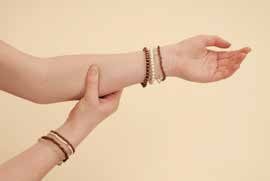

Image from page 56:


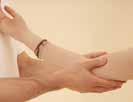

Image from page 68:


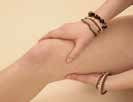

In [8]:
# Initialize the system
rag = MultimodalRAG()

# Process a PDF (replace with your PDF path)
pdf_path = r"C:\Users\yc993\Downloads\final-call\Marma Therapy The Healing Power of Ayurvedic Vital Point Massage.pdf"
rag.extract_content_from_pdf(pdf_path)

# Chat with the system
rag.chat("The wrist Marma Manibandha")

this is streamlit code to provide interface 


In [ ]:
import fitz
from PIL import Image
import io
from transformers import AutoProcessor, AutoModel, AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import os
import tempfile
import streamlit as st

class MultimodalRAG:
    def __init__(self):
        # Check if GPU is available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        print("Initializing models...")
        # Move models to GPU
        self.text_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        self.text_model.to(self.device)

        self.image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.image_model = AutoModel.from_pretrained("openai/clip-vit-base-patch32")
        self.image_model.to(self.device)

        self.chat_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2")
        self.chat_model.to(self.device)

        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")

        self.text_chunks = []
        self.text_embeddings = []
        self.images = []
        self.image_embeddings = []
        self.image_locations = []
        self.page_text_map = {}
        print("Initialization complete!")

    def chunk_text(self, text, chunk_size=500, overlap=100):
        words = text.split()
        chunks = []
        start = 0

        while start < len(words):
            chunk = ' '.join(words[start:start + chunk_size])
            chunks.append(chunk)
            start += chunk_size - overlap

        return chunks

    def process_text(self, text, page_num):
        if not text.strip():
            return

        if page_num not in self.page_text_map:
            self.page_text_map[page_num] = []

        chunks = self.chunk_text(text)
        for chunk in chunks:
            if len(chunk.strip()) > 50:
                self.text_chunks.append(chunk)
                self.page_text_map[page_num].append(chunk)
                # Move input to GPU for encoding
                embedding = self.text_model.encode(chunk, convert_to_tensor=True)
                # Move back to CPU for storage
                embedding = embedding.cpu().numpy()
                self.text_embeddings.append(embedding)

    def extract_content_from_pdf(self, pdf_path):
        print(f"Processing PDF: {pdf_path}")
        doc = fitz.open(pdf_path)
        total_pages = len(doc)

        for page_num in range(total_pages):
            page = doc[page_num]

            # Extract text
            blocks = page.get_text("blocks")
            for block in blocks:
                text = block[4]
                self.process_text(text, page_num)

            # Extract images
            image_list = page.get_images(full=True)
            for img_index, img in enumerate(image_list):
                try:
                    xref = img[0]
                    base_image = doc.extract_image(xref)
                    image_bytes = base_image["image"]

                    image = Image.open(io.BytesIO(image_bytes))
                    if image.mode == 'RGBA':
                        image = image.convert('RGB')

                    # Move input to GPU
                    inputs = self.image_processor(images=image, return_tensors="pt")
                    inputs = {k: v.to(self.device) for k, v in inputs.items()}

                    with torch.no_grad():
                        image_features = self.image_model.get_image_features(**inputs)

                    self.images.append(image)
                    # Move back to CPU for storage
                    self.image_embeddings.append(image_features.cpu().numpy())
                    self.image_locations.append((page_num, img_index))
                except Exception as e:
                    print(f"Error processing image {img_index} on page {page_num}: {str(e)}")
                    continue

        doc.close()

        if self.text_embeddings:
            self.text_embeddings = np.vstack(self.text_embeddings)

        print(f"Processing complete! Found {len(self.text_chunks)} text chunks and {len(self.images)} images.")

    def search(self, query, top_k=3):
        results = {
            'text': [],
            'images': [],
            'text_locations': [],
            'image_locations': [],
            'context': []
        }

        if len(self.text_chunks) > 0:
            # Move query to GPU for encoding
            text_query_embedding = self.text_model.encode(query, convert_to_tensor=True)
            text_query_embedding = text_query_embedding.cpu().numpy()

            text_similarities = cosine_similarity(
                [text_query_embedding],
                self.text_embeddings
            )[0]

            top_text_indices = np.argsort(text_similarities)[-top_k:][::-1]
            results['text'] = [self.text_chunks[i] for i in top_text_indices]
            results['text_locations'] = top_text_indices

            for idx in top_text_indices:
                page_num = None
                for p, chunks in self.page_text_map.items():
                    if self.text_chunks[idx] in chunks:
                        page_num = p
                        break

                if page_num is not None:
                    context = "\n".join(self.page_text_map[page_num])
                    results['context'].append((context, page_num))

        if len(self.images) > 0:
            # Move query to GPU for processing
            image_query_inputs = self.image_processor(text=[query], return_tensors="pt", padding=True)
            image_query_inputs = {k: v.to(self.device) for k, v in image_query_inputs.items()}

            with torch.no_grad():
                image_query_features = self.image_model.get_text_features(**image_query_inputs)

            # Move back to CPU for similarity calculation
            image_query_features = image_query_features.cpu().numpy()

            image_similarities = cosine_similarity(
                image_query_features,
                np.vstack(self.image_embeddings)
            )[0]

            top_image_indices = np.argsort(image_similarities)[-top_k:][::-1]
            results['images'] = [self.images[i] for i in top_image_indices]
            results['image_locations'] = [self.image_locations[i] for i in top_image_indices]

        return results

    def generate_response(self, query, context):
        prompt = f"""Based on the following context, answer the question.

Context: {context}

Question: {query}

Answer: """

        # Correctly handle tokenizer inputs
        inputs = self.tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.chat_model.generate(
                input_ids,
                attention_mask=attention_mask,
                max_new_tokens=512,
                num_return_sequences=1,
                temperature=0.7,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return response.split("Answer: ")[-1].strip()

class StreamlitMultimodalRAG(MultimodalRAG):
    def display_results(self, results):
        if results['text']:
            st.subheader("Relevant Text Contexts:")
            for i, (text, location) in enumerate(zip(results['text'], results['text_locations']), 1):
                st.write(f"Text Chunk {i}:")
                st.write(text)
                st.write("---")

        if results['images']:
            st.subheader("Relevant Images:")
            cols = st.columns(min(3, len(results['images'])))
            for i, (img, loc, col) in enumerate(zip(results['images'], 
                                                  results['image_locations'], 
                                                  cols)):
                with col:
                    st.image(img, caption=f"Image from page {loc[0] + 1}")

def main():
    st.set_page_config(page_title="Multimodal RAG System", 
                      page_icon="🤖",
                      layout="wide")

    st.title("📚 Multimodal RAG System")

    # Initialize session state
    if 'rag_system' not in st.session_state:
        st.session_state.rag_system = None
        st.session_state.pdf_processed = False

    # File uploader
    uploaded_file = st.file_uploader("Upload a PDF document", type=['pdf'])

    if uploaded_file:
        if not st.session_state.pdf_processed:
            with st.spinner("Initializing RAG system and processing PDF..."):
                # Save uploaded file to temporary location
                temp_dir = tempfile.mkdtemp()
                temp_path = os.path.join(temp_dir, uploaded_file.name)
                
                with open(temp_path, 'wb') as f:
                    f.write(uploaded_file.getvalue())

                # Initialize RAG system
                st.session_state.rag_system = StreamlitMultimodalRAG()
                
                # Process the PDF
                st.session_state.rag_system.extract_content_from_pdf(temp_path)
                
                # Clean up
                os.remove(temp_path)
                os.rmdir(temp_dir)
                
                st.session_state.pdf_processed = True
                st.success("PDF processed successfully!")

        # Chat interface
        st.subheader("Ask questions about your document")
        query = st.text_input("Enter your question:")

        if query:
            with st.spinner("Generating response..."):
                # Search for relevant content
                results = st.session_state.rag_system.search(query)

                # Generate response
                context = ""
                if results['context']:
                    context = "\n".join([ctx[0] for ctx in results['context']])
                
                response = st.session_state.rag_system.generate_response(query, context)

                # Display results
                st.write("### Answer:")
                st.write(response)

                # Display relevant content
                st.session_state.rag_system.display_results(results)

    else:
        st.info("Please upload a PDF document to begin.")

        # Reset session state when no file is uploaded
        st.session_state.rag_system = None
        st.session_state.pdf_processed = False

if __name__ == "__main__":
    main()